# Exploring TC PRIMED, Chapter 1b: The Overpass File
- Creators: Naufal Razin, Chris Slocum, and Kathy Haynes
- Affiliations: CIRA and NESDIS/STAR

---

## Overview
TC PRIMED consists of two types of files: the overpass file and the environmental file. The overpass file contains all available satellite products from *one* overpass of a tropical cyclone, while the environmental file contains all available tropical cyclone information, and environmental diagnostics and fields *at synoptic times* (00, 06, 12, 18 UTC) throughout the storm's life. In this notebook, you will learn how to load and plot data from the TC PRIMED overpass file.

## Prerequisites
To successfully navigate and use this notebook, you should be familiar with:
- the basics of Python programming such as loading modules, assigning variables, and list/array indexing
- NetCDF files and NetCDF groups (see Chapter 1a of this Learning Journey)
- plotting data using matplotlib

## Learning Outcomes
By working through this notebook, you should be able to:
- understand the data structure of a TC PRIMED overpass file
- interact with (e.g., load and plot) data from a TC PRIMED overpass file

## Background
Data in the TC PRIMED overpass files are stored in up to six different NetCDF groups. They are:
- `overpass_metadata`, which contains information about the satellite
- `overpass_storm_metadata`, which contains information about the storm at the overpass time
- `passive_microwave`, which contains passive microwave observations of the storm
- `GPROF`, which contains retrieved precipitation variables. Except for a small minority of cases, these are available almost all the time.
- `radar_radiometer`, which contains combined radar-radiometer products from the TRMM PR and GPM DPR (when available)
- `infrared`, which contains infrared observations of the storm and derived metrics (when available)

In this notebook, you will learn to load and plot the field variables, such as the passive microwave and infrared brightness temperatures. In order to successfully do so, you must first understand passive microwave observation data.

As passive microwave sensors orbit the earth on their respective satellites, they rotate and record their observations at each pixel. Each rotation is called a scan, while the size of each pixel is called the instantaneous field-of-view (IFOV). Depending on the sensor architecture, passive microwave brightness temperature observations have different observing frequencies, are available on different grids or swaths, and have different IFOV. The figure below illustrates this concept of different swaths and IFOV using passive microwave observations from the Special Sensor Microwave/Imager (SSM/I), Advanced Microwave Scanning Radiometer 2 (AMSR2), and the Global Precipitation Measurement mission (GPM) Microwave Imager (GMI) sensors.

<figure>
<img alt="An image showing the instantaneous field-of-view for the different observing frequencies of the SSM/I, AMSR2, and GMI sensors." src="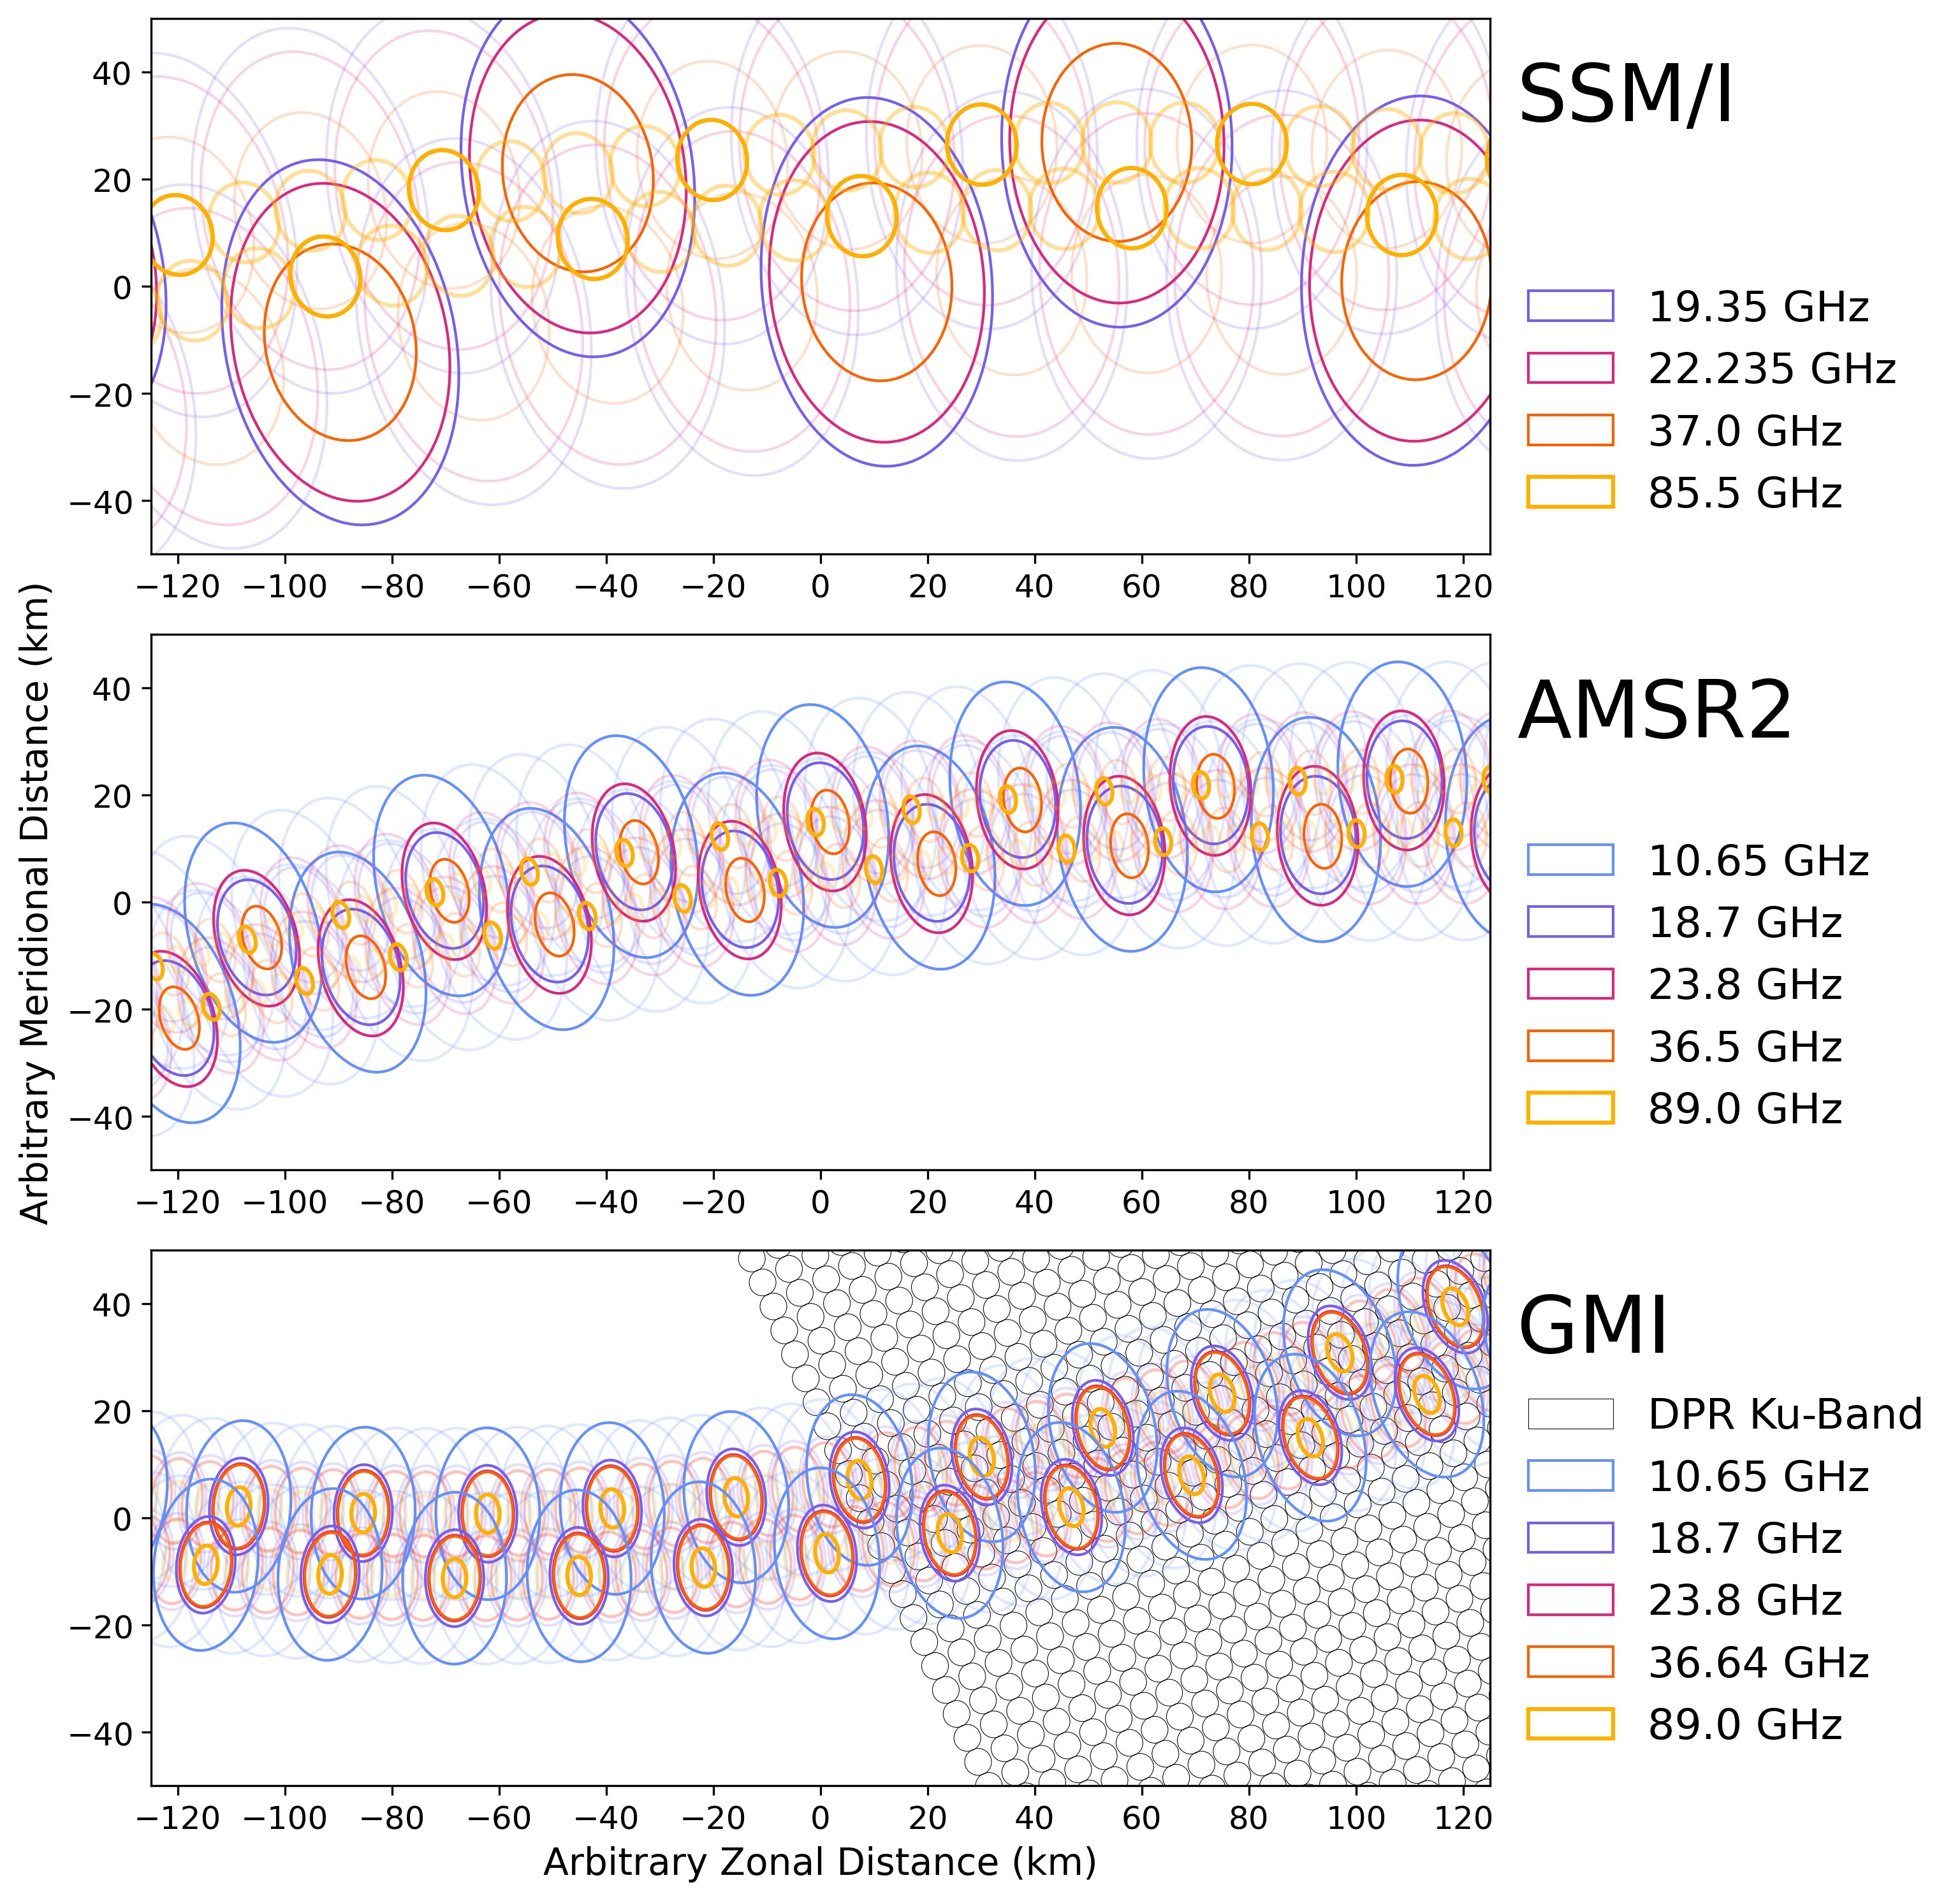" width="700">

<figcaption align = "center"><b>Figure 1.</b> The IFOV for the different observing frequencies of the SSM/I, AMSR2, and GMI sensors. Only two scans are shown, and every fourth pixel highlighted. Also shown is the swath and IFOV for the GPM dual-frequency precipitation radar.</figcaption>
    
</figure>

From Figure 1,
- The SSM/I does not have observations near the 10 GHz frequency, while the GMI has additional observing frequencies at around 166 and 183 GHz, not shown.
- Observations at lower frequencies have a bigger IFOV (lower resolution) than observations at higher frequencies for the same sensor.
- Different sensors have different IFOVs, with SSM/I having the biggest IFOV (lowest resolution) and the GMI generally having the smallest IFOV (highest resolution).
- For the SSM/I, observations in the 19.35 - 37.0 GHz range are located on the same swath, as indicated by their concentric IFOV. Whereas observations in the 85.5 GHz frequency are located on a different swath.
- For the AMSR2, observations in all of the frequencies are located on different swaths. However, the swaths for the 10.65 - 36.5 GHz frequency range are closely collocated.
- For the GMI, observations in the 10.65 - 89.0 GHz frequency range are all located on the same swath.

Note that TC PRIMED contains observations from both conical and cross-track scanners, and the examples in Figure 1 are from conical-scanning passive microwave sensors only. The scanning geometry of conical scanners allow for the IFOV to remain constant. Whereas cross-track-scanning sensors have the highest resolution (smallest IFOV) at the satellite nadir view, which gets coarser (increasing IFOV) towards the edge of the observation swath. For in-depth information on passive microwave remote sensing, including the differences between observations from conical and cross-track scanners, you can sign up for a free [COMET MetEd account](https://www.meted.ucar.edu/index.php) and go through their [passive microwave remote sensing course](https://www.meted.ucar.edu/education_training/course/15). **However, you don't need to go through the course to be able to load and plot the TC PRIMED overpass file data in this notebook.**

Now that you're familiar with the basic concepts around passive microwave observations, let's learn how to load and plot them from a TC PRIMED overpass file. We will be using an overpass file from Hurricane Florence (2018), as observed by the cross-track-scanning Advanced Technology Microwage Sounder (ATMS) sensor aboard the NOAA-20 satellite.

<figure>
<img alt="An image of Hurricane Florence (2018) captured by European Space Agency astronaut Alexander Gerst from aboard the International Space Station." src="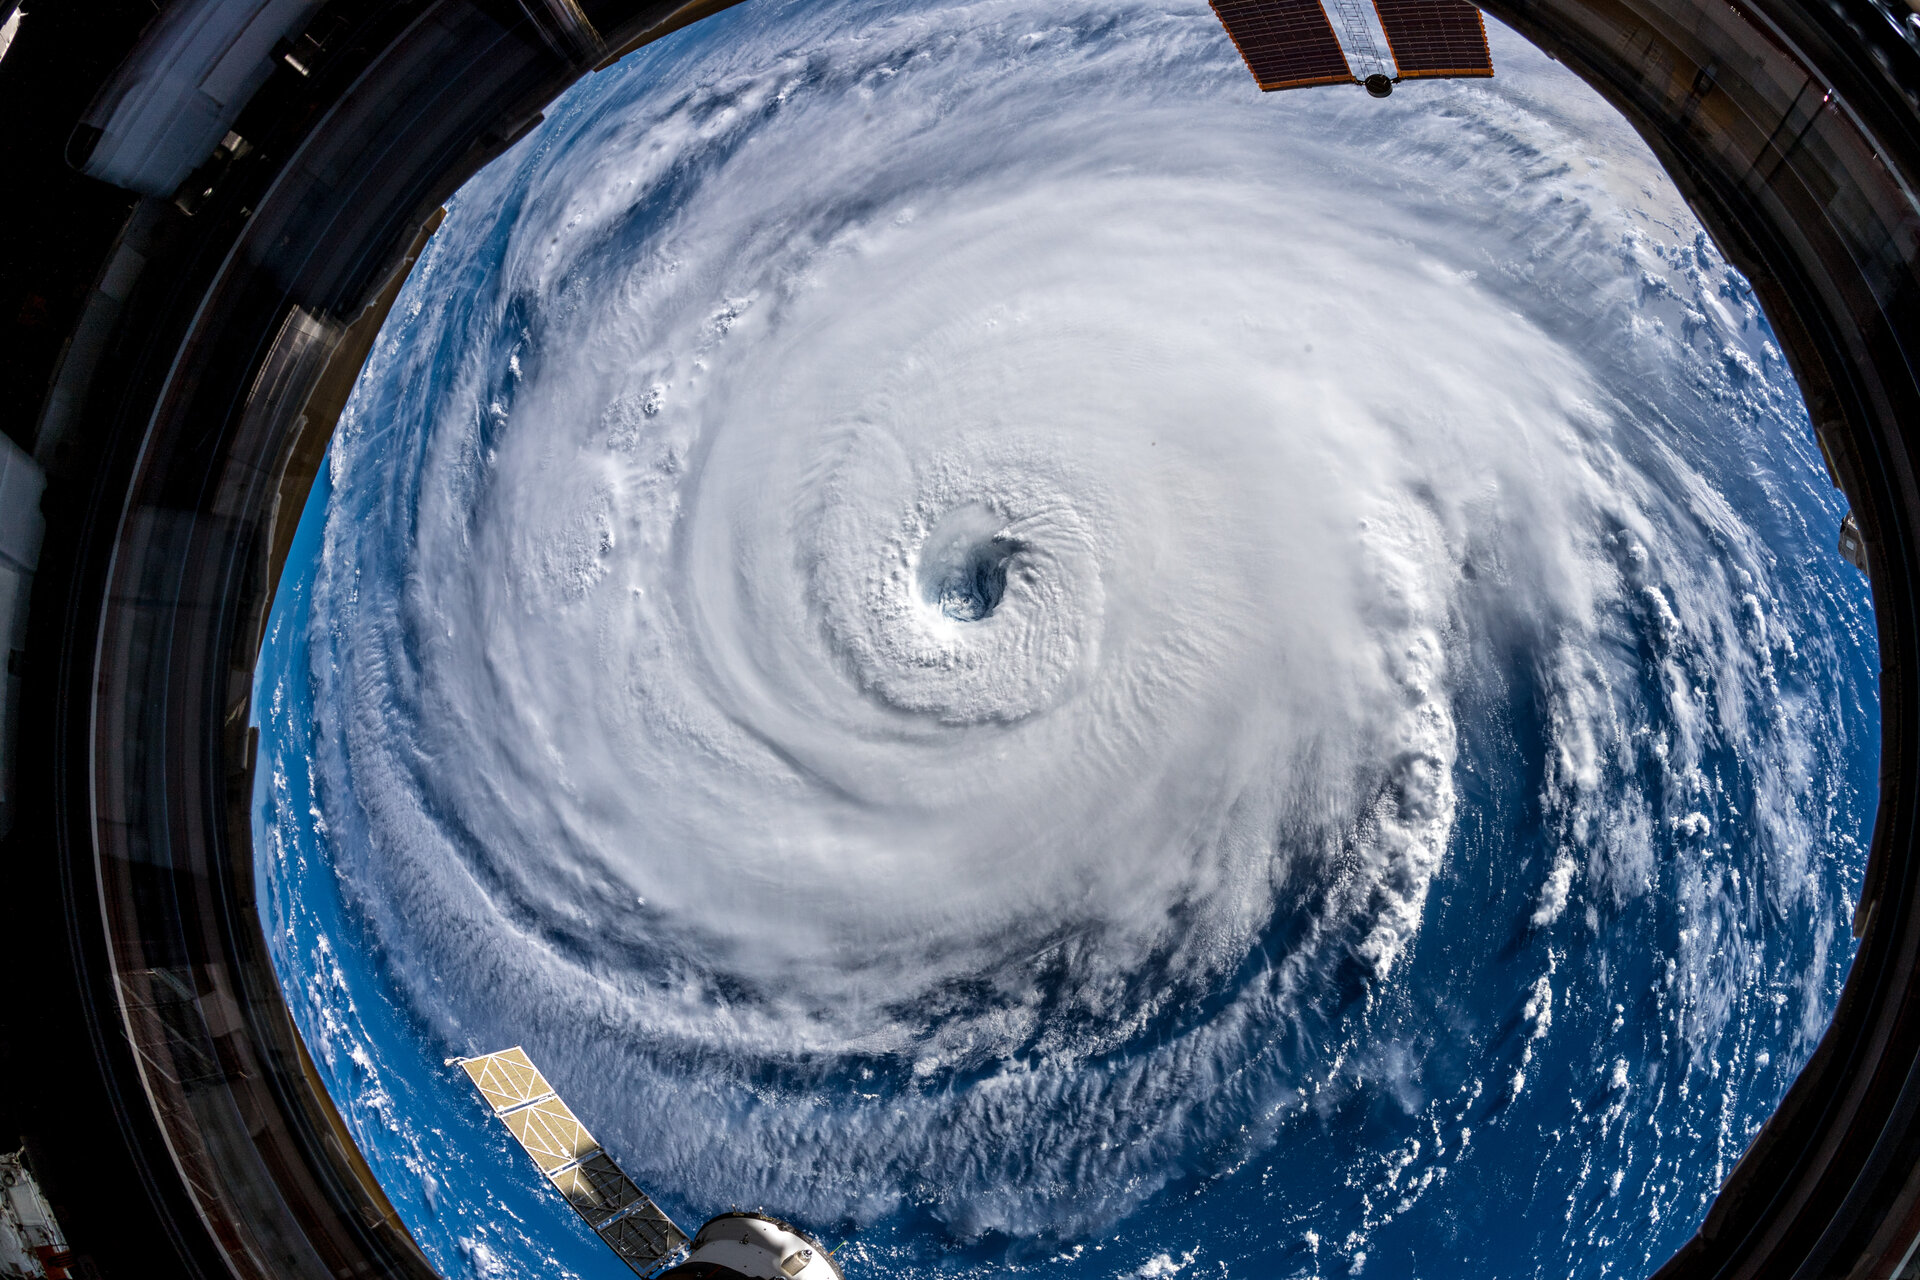" width="900">

<figcaption align = "center"><b>Figure 2.</b> An image of Hurricane Florence (2018) captured by European Space Agency astronaut Alexander Gerst from aboard the International Space Station. Source: <a href="https://www.esa.int/ESA_Multimedia/Images/2018/09/Above_Hurricane_Florence">ESA</a></figcaption>
    
</figure>

Hurricane Florence was a long-lived hurricane that formed off the coast of Senegal and The Gambia, and tracked westward across the North Atlantic Ocean. During its track across the Atlantic, it briefly intensified to a Category 4 hurricane (on the [Saffir-Simpson Hurricane Wind Scale](https://www.nhc.noaa.gov/aboutsshws.php#:~:text=The%20Saffir%2DSimpson%20Hurricane%20Wind,Scale%20estimates%20potential%20property%20damage.)), weakened to a tropical storm, and re-intensified back to a Category 4 hurricane before making landfall along the southeastern coast of North Carolina as a high-end Category 1 hurricane. Florence brought [record-breaking rainfall](https://www.weather.gov/ilm/HurricaneFlorence) across eastern North Carolina and parts of northeastern South Carolina.

The ATMS observation of Hurricane Florence that you will load and plot is from September 4th, 2018, when Florence was a Category 1 hurricane before it intensified to a Category 4 hurricane for the first time.

## Software
This tutorial uses the Python programming language and packages. We will use:
- `netCDF4` to load the TC PRIMED file
- `matplotlib` to plot the data

### Install Packages
Let's first check if we have the necessary Python packages to run this notebook. If we don't, let's install them.

In [ ]:
import subprocess, sys
packages = ["netCDF4", "matplotlib"]
for package in packages:
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

Now, let's load the modules in the packages (e.g., `Dataset`) or load the packages and assign a shorter object name for the packages (e.g., `import matplotlib.pyplot as plt`) for a cleaner use throughout the notebook.

In [ ]:
# Load the Python packages we will use in this notebook
from netCDF4 import Dataset
import matplotlib.pyplot as plt
plt.rcParams['pcolor.shading'] = 'auto'

## Read File Online
Finally, let's retrieve information from the TC PRIMED file that we will use in this example. As we have mentioned above, the TC PRIMED file will be from an ATMS overpass of Hurricane Florence (2018). We will use the Python `netCDF4` and `requests` packages to read and retrieve the information directly from the TC PRIMED file available on an Amazon Web Service S3 bucket as part of the NOAA Open Data Dissemination program (NODD), without downloading the file, and store the information from the file in an "instance" type called `DS`.

In [ ]:
import requests

# Specify the URL to the TC PRIMED folder on NODD
NODD_URL = "https://noaa-nesdis-tcprimed-pds.s3.amazonaws.com/v01r00/final/2018/AL/06/"

# Specify the name of the file we will use from the TC PRIMED folder on NODD
FILE_NAME = "TCPRIMED_v01r00-final_AL062018_ATMS_NOAA20_004112_20180904043704.nc"

# Join NODD_URL and FILE_NAME to produce a complete link
# Retrieve the contents of the TC PRIMED file from the complete link
url_response = requests.get(NODD_URL + FILE_NAME)

# Load the contents of the TC PRIMED file in an "instance" called DS
DS = Dataset(FILE_NAME, memory=url_response.content)

## Part 1: Loading and plotting passive microwave data
As discussed in the [background](#Background), passive microwave observations are available on different swaths, depending on the sensor type. To load variables from a particular swath, you would point to the variable within the `passive_microwave` group and swath sub-group (e.g., `S1` or `S2`, etc.). The [dataset documentation](https://noaa-nesdis-tcprimed-pds.s3.amazonaws.com/TCPRIMED_v01r00_documentation.pdf) provides information on the swaths that are available for each TC PRIMED sensor. However, you can also identify the passive microwave swaths that are available in a TC PRIMED overpass files by printing out the `passive_microwave` group instance. Let's take a look at the available swaths for the ATMS sensor.

In [ ]:
# Using the file instance, load the passive_microwave group as a
# group instance called passive_microwave_group
passive_microwave_group = DS["passive_microwave"]

# Print the passive_microwave group instance
print(passive_microwave_group)

Notice from the print out above of the `passive_microwave` group instance, there are four groups associated with four swaths `S1`, `S2`, `S3`, and `S4` for the ATMS sensor. Each of these groups will have its own set of latitude and longitude information associated with the swath, along with the brightness temperature values from the particular observing frequency associated with the swath. You can query these groups individually to search for the particular observing frequency in which you are interested, or refer to the [dataset documentation](https://noaa-nesdis-tcprimed-pds.s3.amazonaws.com/TCPRIMED_v01r00_documentation.pdf). For brevity, let's move on to loading the 88.2 GHz quasi-vertical polarization brightness temperature data from the `S3` swath.

In [ ]:
# Using the file instance, load the latitude, longitude, and brightness
# temperature variable from the S3 sub-group in the passive_microwave
# group by specifying its "path" in the file and using [:] to load the variable
S3_latitude = DS["passive_microwave/S3/latitude"][:]     # Latitude of observations on swath S3
S3_longitude = DS["passive_microwave/S3/longitude"][:]   # Longitude of observations on swath S3
S3_88V = DS["passive_microwave/S3/TB_88.2QV"][:]         # 88.2 GHz quasi-vertical-polarization
                                                         # brightness temperature observations on swath S3

Fantastic! You've successfully loaded passive microwave data from a TC PRIMED overpass file. Let's now plot the brightness temperature data using `matplotlib`.

In [ ]:
# Set figure size
plt.figure(figsize=[10,6])

# Plot data as colormesh, with the "nipy_spectral_r" colormap
plt.pcolormesh(S3_longitude, S3_latitude, S3_88V, cmap="viridis")

# Add and label the colorbar
plt.colorbar(pad=-0.04, fraction=0.03, label="88.2 GHz Brightness Temperature (Kelvin)")

# Scale the aspect ratio of the figure so that 1 degree longitude = 1 degree latitude
plt.axis("scaled")

# Add latitude and longitude labels
plt.xlabel("Longitude (degrees east)")
plt.ylabel("Latitude (degrees north)")

As you can see, the plot shows the ATMS scans within the vicinity of Hurricane Florence (2018). However, Hurricane Florence is shifted to the right of the image. How do you center the image? To do so, you can use the storm center location from the overpass file. The storm center location is in the `overpass_storm_metadata` group of the TC PRIMED overpass files. If you're wondering what other variables are available in the `overpass_storm_metadata`, you can always print out their instances.

The storm_latitude and storm_longitude data in the `overpass_storm_metadata` group are in a one-element array. Let's just obtain the array element by first loading the variable using `[:]` and then pulling out the element by supplying an array index of `[0]`.

In [ ]:
# Using the file instance, load the storm_latitude and storm_longitude
# from the overpass_storm_metadata group by specifying its "path" in
# the file, using [:] to load the variable, and using [0] to load the
# single element in the variable array
storm_latitude = DS["overpass_storm_metadata/storm_latitude"][:][0]
storm_longitude = DS["overpass_storm_metadata/storm_longitude"][:][0]

Now that you've loaded the `storm_latitude` and `storm_longitude` values, use `xlim` and `ylim` to constrain the image within +/- 7.5 degree latitude and longitude of the storm center

In [ ]:
# Set figure size
plt.figure(figsize=[6,6])

# Plot data as colormesh, with the "nipy_spectral_r" colormap
plt.pcolormesh(S3_longitude, S3_latitude, S3_88V, cmap="viridis")

# Add and label the colorbar
plt.colorbar(pad=0.02, fraction=0.047, label="88.2 GHz Brightness Temperature (Kelvin)")

# Scale the aspect ratio of the figure so that 1 degree longitude = 1 degree latitude
plt.axis("scaled")

# Add latitude and longitude labels
plt.xlabel("Longitude (degrees east)")
plt.ylabel("Latitude (degrees north)")

# Constrain the image to within +/- 7.5 degree latitude and longitude of the
# storm center
plt.xlim(storm_longitude - 7.5, storm_longitude + 7.5)
plt.ylim(storm_latitude - 7.5, storm_latitude + 7.5)

Wonderful! Note that you can use the storm location from the `overpass_storm_metadata` group to re-center any other data from the satellite, such as data from the `GPROF` group or data from the `radar_radiometer` group (for the TRMM and GPM satellites)

<div class="alert alert-block alert-success">
<h3>Exercise 1</h3> Using the example above, load and plot the 165.5 GHz quasi-horizontal-polarization brightness temperature from the <code>S4<code> swath.
</div>

<div class="alert alert-block alert-info">
    <b>Hint:</b> Print out the <code>S4</code> group instance from the <code>passive_microwave</code> group to identify the variables you would want to load.
</div>

## Part 2: Reading in and plotting GPROF data
Since rainfall retrievals from the Goddard PROFiling algorithm (GPROF) derive from the passive microwave observations, GPROF data follows a similar structure to the passive microwave data. However, instead of having multiple swaths, GPROF data is located on only one swath, `S1`.

Before we load and plot the surface precipitation data from GPROF, note that for a small minority of cases, GPROF data isn't available even though its corresponding passive microwave data is available. To indicate data availability, we use availability flags, with a value of 0 indicating that the data is not available and a value of 1 indicating that the data is available. Let's first retrieve this availability flag.

In [ ]:
# Using the file instance, load the availability_flag
# from the GPROF group by specifying its "path" in
# the file, using [:] to load the variable, and using [0]
# to load the single element in the variable array
gprof_flag = DS["GPROF/availability_flag"][:][0]

# Print the GPROF availability flag
print(gprof_flag)

Now that we know that GPROF data is available, we can proceed. There are a few GPROF variables that you can load and plot. They are listed in the file and in the [dataset documentation](https://noaa-nesdis-tcprimed-pds.s3.amazonaws.com/TCPRIMED_v01r00_documentation.pdf). However, here, we'll load and plot the GPROF surface precipitation rate.

In [ ]:
# Using the file instance, load the latitude, longitude, and surface
# precipitation variable from the S1 sub-group in the GPROF
# group by specifying its "path" in the file and using [:] to load the variable
S1_latitude = DS["GPROF/S1/latitude"][:]                # Latitude of observations on GPROF swath S1
S1_longitude = DS["GPROF/S1/longitude"][:]              # Longitude of observation on GPROF swath S1
S1_sfcprcp = DS["GPROF/S1/surfacePrecipitation"][:]     # surface precipitation rate from GPROF swath S1

In [ ]:
# Set figure size
plt.figure(figsize=[6,6])

# Plot data as colormesh, with the "Blues" colormap
plt.pcolormesh(S1_longitude, S1_latitude, S1_sfcprcp, cmap="Blues")

# Add and label the colorbar
plt.colorbar(pad=0.02, fraction=0.047, label="GPROF Surface Precipitation (mm/hr)")

# Scale the aspect ratio of the figure so that 1 degree longitude = 1 degree latitude
plt.axis("scaled")

# Add latitude and longitude labels
plt.xlabel("Longitude (degrees east)")
plt.ylabel("Latitude (degrees north)")

# Constrain the image to within +/- 7.5 degree latitude and longitude of the
# storm center
plt.xlim(storm_longitude - 7.5, storm_longitude + 7.5)
plt.ylim(storm_latitude - 7.5, storm_latitude + 7.5)

## Part 3: Loading and plotting near-coincident infrared data
The TC PRIMED overpass files also contain nearly-coincident infrared brightness temperatures from a geostationary satellite along with derived variables like the infared-based size parameter, R5 (Knaff et al. 2014, 2017). However, just like the GPROF product, both the infared and R5 data may or may not be available, with their availability marked by an availability flag.

In addition, since the infrared data may be available any time within 3 hours of the overpass time, the storm center location in the infared data may not be the same as the storm center location in the passive microwave or GPROF data. Therefore, when infrared data is available, the infrared group also stores the storm center latitude and longitude at the infrared observation time.

Finally, the infrared data does not have the swath structure associated with the passive microwave observations. Therefore, you will not need to refer to a specific swath when loading infrared data.

<div class="alert alert-block alert-success">
<h2>Practice</h2> Using what you've learned from loading and plotting the passive microwave and GPROF data above
    <ul>
        <li>print out the infrared availability flag</li>
        <li>load and plot the infrared data, centered on the storm center at the infrared observation time</li>
    </ul>
</div>

<div class="alert alert-block alert-info">
<b>Hint:</b> Print out the <code>infrared</code> group instance to identify the names of the variables you want to obtain.
<div>

## Close the File
When loading data from a NetCDF file, **always remember to close the file**. A best practice would be to close the file immediately after loading the variable or attribute of interest. However, since we're loading various variables and attributes throughout this notebook, we will close the file at the end of this notebook using the command below.

In [ ]:
DS.close()

## Final Thoughts
There are a host of other variables you can obtain and plot from the TC PRIMED overpass file. However, the basic concepts of loading and plotting/printing that you learned in this tutorial also apply to those variables. To recap, in this tutorial, you learned:
- about the basic structure of a TC PRIMED overpass file
- how to load and plot data from the TC PRIMED overpass file
- how to determine data availability in the TC PRIMED overpass file using the availability flag

## Data Statement

- Razin, Muhammad Naufal; Slocum, Christopher J.; Knaff, John A.; Brown, Paula J. 2023. Tropical Cyclone PRecipitation, Infrared, Microwave, and Environmental Dataset (TC PRIMED). v01r00. NOAA National Centers for Environmental Information. https://doi.org/10.25921/dmy1-0595.

## References
- Knaff, J. A., S. P. Longmore, and D. A. Molenar, 2014: An objective satellite-based tropical cyclone size climatology. J. Climate, 27, 455–476, https://doi.org/10.1175/JCLI-D-13-00096.1.

- Knaff, J. A., C. R. Sampson, and G. Chirokova, 2017: A global statistical-dynamical tropical cyclone wind radii forecast scheme. Wea. Forecasting, 32, 629–644, https://doi.org/10.1175/WAF-D-16-0168.1.

## Metadata
- Language / package(s)
     - Python
     - NetCDF
     - Matplotlib
- Domain
    - NOAA
    - NASA
- Application keywords
    - Satellite passive microwave
    - Goddard Profiling algorithm (GPROF)
- Geophysical keywords
    - Tropical cyclones